In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time
import math
import netCDF4 as nc

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing

#  32.5,  33.5
# -97.5, -96.5
RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

In [2]:
folder = "spatial"
node_id = "10004098"
dir_out = "../figures/" + folder + "/"
dir_data = "../data/"

fn_in = dir_data + "driving_" + node_id + "_NEXRAD.csv"


In [3]:
df_all = pd.read_csv(fn_in, parse_dates=True, index_col = 'UTC')

In [5]:
# df_all[(df_all.index.date == datetime.date(2020,4,15)) & (df_all.index.hour == 15) & (df_all.index.minute == 43) ]['spectrum_width 0km']

In [4]:
# drop a few rows with NaN values, NEXRAD file on "20200415_154344" has less keys, no 'velocity' and 'spectrum_width'
df = df_all.dropna()
# refill the -inf values
df = df.replace(-np.Inf, -9999.0)

In [5]:
# Illuminance, 421 bins(360nm-780nm), lat,long,alt, features
features = df.columns[1+421+3:]
target = df.columns[0] # 'Illuminance'

In [6]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [7]:
n_components = 10 #len(features)

DR = 'PCA'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_train_DR = pca.fit_transform(X_train)
X_test_DR = pca.transform(X_test)

X_train_DR = pd.DataFrame(X_train_DR)
X_test_DR = pd.DataFrame(X_test_DR)
print(pca.explained_variance_/np.sum(pca.explained_variance_))

# # save pca model
# dir_DR = '../models/spatial_' + node_id + '/'
# if not os.path.exists(dir_DR):
#     os.mkdir(dir_DR)

# fn_DR = dir_DR + DR + '.sav'
# pickle.dump(pca, open(fn_DR, 'wb'))

[9.99999998e-01 1.61585555e-09 2.18325409e-10 1.08612471e-10
 9.61501433e-11 7.45790753e-11 6.95223692e-11 6.78769536e-11
 6.31079006e-11 5.47673440e-11]


In [102]:
start_time = time.time()

# Random Forest Model, grid search to find best parameter
rfr = RandomForestRegressor(random_state = RANDOM_STATE, oob_score=True, n_jobs = n_jobs)
param_grid = {'max_depth': list(range(1,50+1)),
              'n_estimators': list(range(20,100+1)),
              'min_samples_split': list(range(2,50+1)),
              'min_samples_leaf': list(range(1,10+1)),
              'max_features': np.array(list(range(1,10+1)))/10,
              'max_samples': list(np.array(list(range(1,10)))/10) + [None]
             }
CV_rfr = RandomizedSearchCV(estimator = rfr, param_distributions = param_grid,
                            n_iter = 500, cv =2, verbose = 3)

CV_rfr.fit(X_train_DR, y_train)
print(CV_rfr.best_params_)
print(CV_rfr.best_score_)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[CV 1/2] END max_depth=4, max_features=0.9, max_samples=0.7, min_samples_leaf=3, min_samples_split=10, n_estimators=60; total time=   3.7s
[CV 2/2] END max_depth=4, max_features=0.9, max_samples=0.7, min_samples_leaf=3, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV 1/2] END max_depth=45, max_features=0.3, max_samples=0.3, min_samples_leaf=8, min_samples_split=13, n_estimators=42; total time=   0.2s
[CV 2/2] END max_depth=45, max_features=0.3, max_samples=0.3, min_samples_leaf=8, min_samples_split=13, n_estimators=42; total time=   0.2s
[CV 1/2] END max_depth=28, max_features=0.4, max_samples=0.7, min_samples_leaf=3, min_samples_split=18, n_estimators=98; total time=   0.6s
[CV 2/2] END max_depth=28, max_features=0.4, max_samples=0.7, min_samples_leaf=3, min_samples_split=18, n_estimators=98; total time=   0.6s
[CV 1/2] END max_depth=41, max_features=0.5, max_samples=None, min_samples_leaf=8, min_samples_spl

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.


[CV 1/2] END max_depth=10, max_features=0.1, max_samples=None, min_samples_leaf=4, min_samples_split=13, n_estimators=21; total time=   0.2s


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.


[CV 2/2] END max_depth=10, max_features=0.1, max_samples=None, min_samples_leaf=4, min_samples_split=13, n_estimators=21; total time=   0.2s
[CV 1/2] END max_depth=16, max_features=1.0, max_samples=0.2, min_samples_leaf=4, min_samples_split=18, n_estimators=58; total time=   0.6s
[CV 2/2] END max_depth=16, max_features=1.0, max_samples=0.2, min_samples_leaf=4, min_samples_split=18, n_estimators=58; total time=   0.6s
[CV 1/2] END max_depth=23, max_features=0.1, max_samples=0.4, min_samples_leaf=10, min_samples_split=14, n_estimators=94; total time=   0.6s
[CV 2/2] END max_depth=23, max_features=0.1, max_samples=0.4, min_samples_leaf=10, min_samples_split=14, n_estimators=94; total time=   0.6s
[CV 1/2] END max_depth=43, max_features=0.2, max_samples=0.9, min_samples_leaf=9, min_samples_split=5, n_estimators=76; total time=   0.7s
[CV 2/2] END max_depth=43, max_features=0.2, max_samples=0.9, min_samples_leaf=9, min_samples_split=5, n_estimators=76; total time=   0.7s
[CV 1/2] END max_de

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.


[CV 1/2] END max_depth=34, max_features=0.7, max_samples=None, min_samples_leaf=10, min_samples_split=12, n_estimators=21; total time=   0.3s


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.


[CV 2/2] END max_depth=34, max_features=0.7, max_samples=None, min_samples_leaf=10, min_samples_split=12, n_estimators=21; total time=   0.3s
[CV 1/2] END max_depth=30, max_features=0.9, max_samples=0.8, min_samples_leaf=10, min_samples_split=29, n_estimators=91; total time=   1.1s
[CV 2/2] END max_depth=30, max_features=0.9, max_samples=0.8, min_samples_leaf=10, min_samples_split=29, n_estimators=91; total time=   1.1s
[CV 1/2] END max_depth=45, max_features=0.2, max_samples=0.3, min_samples_leaf=1, min_samples_split=50, n_estimators=89; total time=   0.4s
[CV 2/2] END max_depth=45, max_features=0.2, max_samples=0.3, min_samples_leaf=1, min_samples_split=50, n_estimators=89; total time=   0.4s
[CV 1/2] END max_depth=34, max_features=0.6, max_samples=0.5, min_samples_leaf=7, min_samples_split=50, n_estimators=49; total time=   0.4s
[CV 2/2] END max_depth=34, max_features=0.6, max_samples=0.5, min_samples_leaf=7, min_samples_split=50, n_estimators=49; total time=   0.4s
[CV 1/2] END max

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.


[CV 1/2] END max_depth=47, max_features=0.8, max_samples=None, min_samples_leaf=7, min_samples_split=46, n_estimators=22; total time=   0.3s


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.


[CV 2/2] END max_depth=47, max_features=0.8, max_samples=None, min_samples_leaf=7, min_samples_split=46, n_estimators=22; total time=   0.3s
[CV 1/2] END max_depth=48, max_features=0.4, max_samples=0.1, min_samples_leaf=8, min_samples_split=21, n_estimators=55; total time=   0.2s
[CV 2/2] END max_depth=48, max_features=0.4, max_samples=0.1, min_samples_leaf=8, min_samples_split=21, n_estimators=55; total time=   0.2s
[CV 1/2] END max_depth=27, max_features=0.4, max_samples=0.6, min_samples_leaf=4, min_samples_split=40, n_estimators=50; total time=   0.3s
[CV 2/2] END max_depth=27, max_features=0.4, max_samples=0.6, min_samples_leaf=4, min_samples_split=40, n_estimators=50; total time=   0.3s
[CV 1/2] END max_depth=36, max_features=0.4, max_samples=0.1, min_samples_leaf=6, min_samples_split=29, n_estimators=31; total time=   0.1s
[CV 2/2] END max_depth=36, max_features=0.4, max_samples=0.1, min_samples_leaf=6, min_samples_split=29, n_estimators=31; total time=   0.1s
[CV 1/2] END max_de

In [8]:
max_depth = 50 #CV_rfr.best_params_['max_depth'], # 30
n_estimators = 80 #CV_rfr.best_params_['n_estimators'])#100
min_samples_split = 6
min_samples_leaf = 3
max_samples = None
max_features = 0.9

regr = RandomForestRegressor(random_state = RANDOM_STATE,
                             max_depth = max_depth,
                             n_estimators = n_estimators,
                             min_samples_split = min_samples_split,
                             min_samples_leaf = min_samples_leaf,
                             max_samples = max_samples,
                             max_features = max_features,
                             n_jobs = n_jobs)
regr.fit(X_train_DR, y_train)

RandomForestRegressor(max_depth=50, max_features=0.9, min_samples_leaf=3,
                      min_samples_split=6, n_estimators=80, n_jobs=8,
                      random_state=42)

In [9]:
structure =  '_dep' + str(max_depth) \
            +'_ne' + str(n_estimators) \
            +'_splt' + str(min_samples_split) \
            +'_lf' + str(min_samples_leaf)\
            +'_sr' + str(max_samples)\
            +'_fr' + str(max_features)
fn_model = '../models/spatial_RF_' + target + structure +'.sav'
pickle.dump(regr, open(fn_model, 'wb'))


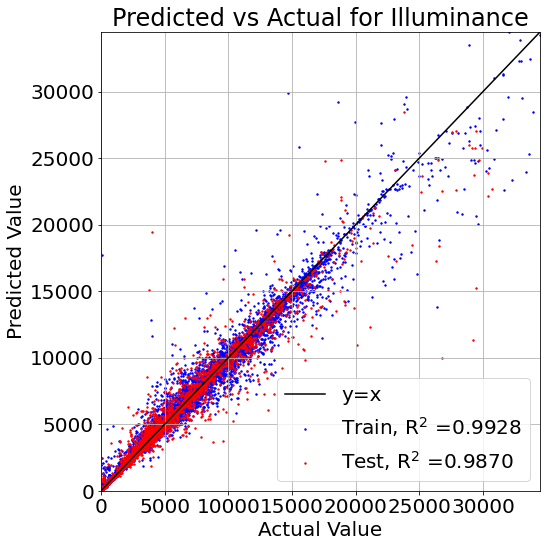

In [10]:
from sklearn.metrics import r2_score
y_train_pred = regr.predict(X_train_DR)
train_score = r2_score(y_train, y_train_pred)

y_test_pred = regr.predict(X_test_DR)
test_score = r2_score(y_test, y_test_pred)

y_min = 0 # np.amin(y_train.values)
y_max = np.amax(y_train.values)
y_mean = np.mean(y_train.values)
y_std = np.std(y_train.values)
y_line = np.linspace(y_min,y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,y_train_pred, s=2, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,y_test_pred, s=2, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((y_min, y_mean + 2*y_std))
plt.ylim((y_min, y_mean + 2*y_std))
ax.set_title('Predicted vs Actual for ' + target)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/spatial_RF_performance_'+target+structure+'.png')


In [13]:
# Create object that can calculate shap values
num_shap = 1000
X_sample = shap.sample(X_train_DR, num_shap)
explainer = shap.TreeExplainer(regr)
# Calculate shap_values
shap_values = explainer.shap_values(X_sample)

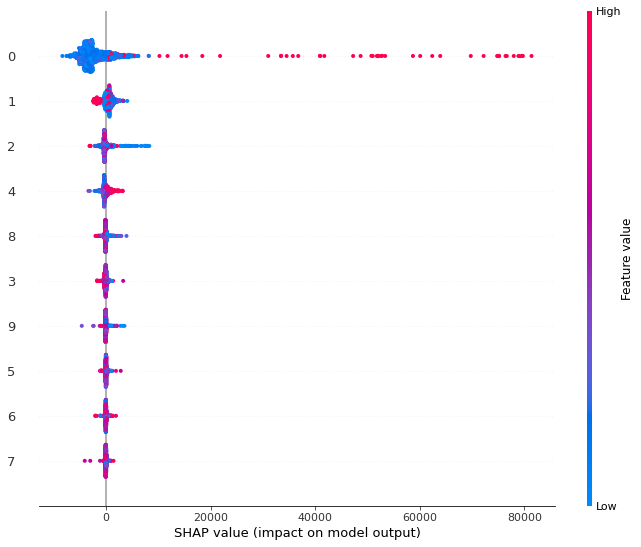

In [14]:
# plot
shap.summary_plot(shap_values, X_sample,
                  plot_size=(10,8),#'auto'
                  max_display = 30,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + target + '/spatial_RF_shap_'+ target +'.png')